Weź dane z poniższej lokalizacji:
https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv

Wykonaj analizę i model dla tego zbioru:
1. Wytypuj przykładowe zdjęcie lub kilka, spróbuj je wczytać, wykonaj z jednym z nich analogiczne zagadnienia jak podczas zajęć (m.in. zamiana na zdjęcie czarno białe).
2. Po kolejnym zjeździe wczytaj wszystkie zdjęcia i spróbuj stworzyć model sieci neuronowej, który będzie w stanie rozpoznać płeć dziecka ze zdjęcia.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

Wczytanie danych i krótka analiza

In [3]:
file = pd.read_csv("age_gender.csv")

In [4]:
file.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [5]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


kolumnę "pixels" trzeba będzie przekształcić najpierw na int a nastepnie na array

In [6]:
def plot_destribution(df, feature):
    plt.figure(figsize=(20,7))
    df[str(feature)].value_counts().sort_index().plot(kind='bar')
    plt.ylabel("counts")
    plt.xlabel(feature)
    plt.title(feature.upper()+" destribution")

krótka analiza ilości danych

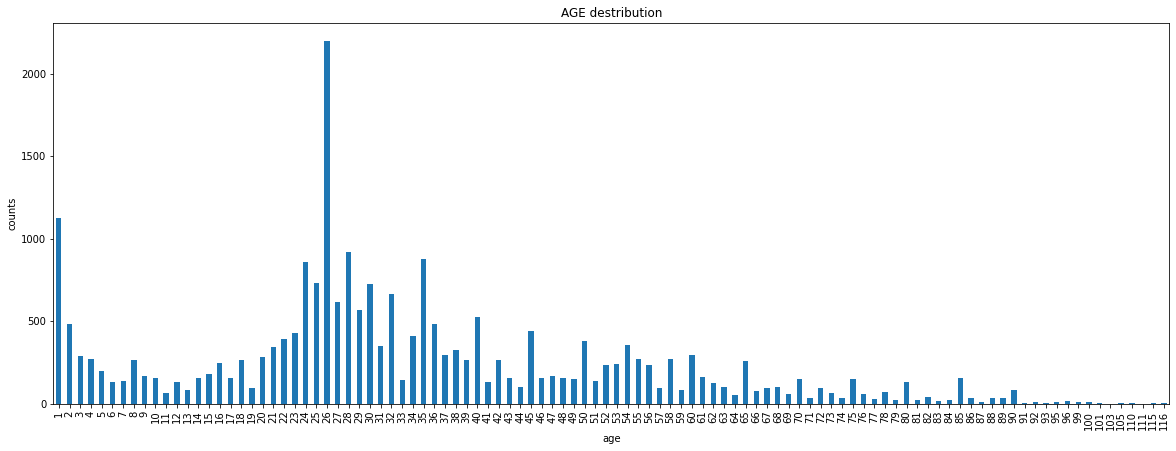

In [7]:
plot_destribution(file, "age")

Już na samym początku można zauważyć, że pojawia się tendencja do zaokrąglania wieku (zwłaszcza przy wartościach powyżej 30 lat)  
Stąd już pierwsza uwaga, że predekcja może się mylić o kilka lat

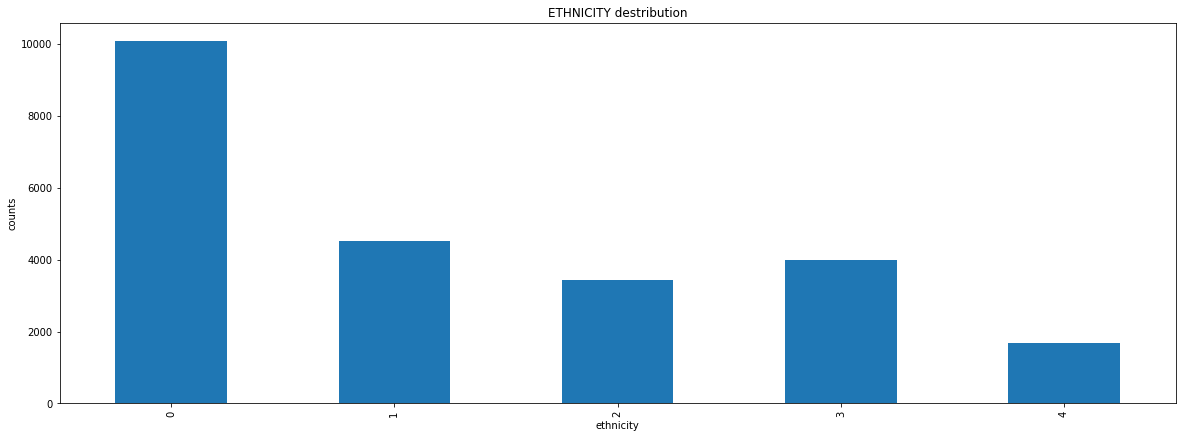

In [8]:
plot_destribution(file, "ethnicity")

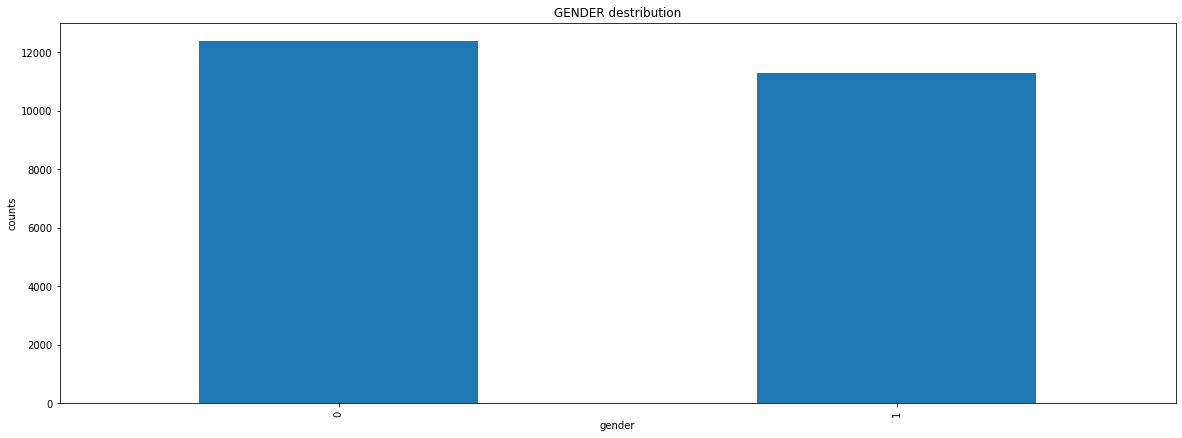

In [9]:
plot_destribution(file, "gender")

Wczytywanie zdjęcia

In [10]:
id = 0
pic = file["pixels"][id]
pic[:100]

'129 128 128 126 127 130 133 135 139 142 145 149 147 145 146 147 148 149 149 150 153 153 153 152 153 '

dane z każdego zdjęcia są w formie jednego, ciągłego stringa  
wyodrębniamy każdą pojedyńczą wartośc do listy:

In [11]:
pic = pic.split(" ")
pic[:10]

['129', '128', '128', '126', '127', '130', '133', '135', '139', '142']

In [12]:
type(pic)

list

In [13]:
type(pic[0])

str

wartości w liscie nadal są stringami, więc zmianiamy ich typ na integer

In [14]:
pic2 = []
for p in pic:
    pn = int(p)
    pic2.append(pn)
pic2[:10]

[129, 128, 128, 126, 127, 130, 133, 135, 139, 142]

a następnie na array

In [15]:
arr = np.array(pic2)
arr

array([129, 128, 128, ..., 146, 146, 146])

In [16]:
type(arr[0])

numpy.int32

obliczamy wielkość zdjęcia (zakładając, że jest kwadratowe) i przekształcamy array do odpowiedniej formy

In [17]:
shape = arr.shape
shape

(2304,)

In [18]:
side_len = np.sqrt(shape[0]).astype(int)
side_len

48

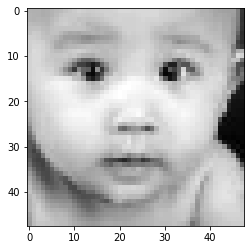

In [19]:
picture = arr.reshape(side_len, side_len)
plt.imshow(picture, cmap='gray');

przygotowanie danych do DL

In [20]:
file_reduced = file[file["age"]<=25] # zredukowanie danych dla przyspieszenia obliczen

In [78]:
print("przed reudkcją:", file["age"].count())
print("   po redukcji:", file_reduced["age"].count())

przed reudkcją: 23705
   po redukcji: 7637


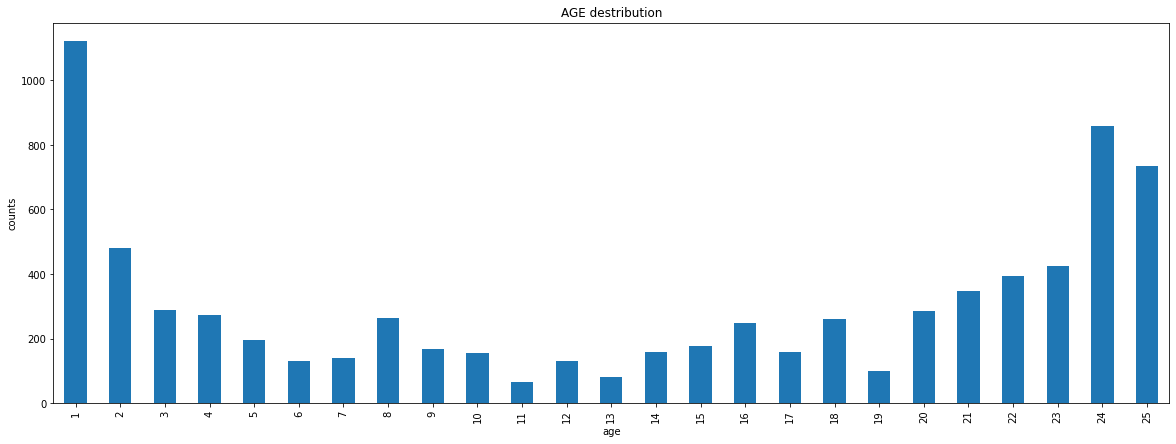

In [22]:
plot_destribution(file_reduced,"age")

tworzenie jednego arraya z datasetu

In [23]:
pic_arr = picture.reshape(1,48,48)      # pierwszy obrazek z datasetu
for pic in file_reduced["pixels"][1:]:  # petla dla wszystkich obrazkow z pominieciem pierwszego
    pic = pic.split(" ")
    pic2 = []
    for p in pic:
        pn = int(p)
        pic2.append(pn)
    temp_pic = np.array(pic2).reshape(1,48,48)
    pic_arr = np.concatenate((pic_arr, temp_pic), axis=0) 

pic_arr.shape

(7637, 48, 48)

In [24]:
x = pic_arr.reshape(-1,48,48,1)
y = file_reduced["gender"]

In [57]:
x.shape

(7637, 48, 48, 1)

In [58]:
y.shape

(7637,)

dzielenie zbioru na treningowu i testowy

In [59]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [60]:
def plot_loss_acc(results):
    fig=plt.figure(figsize=(20,10))
    plt.plot(results.history['loss'])
    plt.plot(results.history['accuracy'])
    plt.legend(["loss","accuracy"])
    plt.show()

tworzymy model DL

In [61]:
from tensorflow.keras import layers

In [75]:
model = tf.keras.models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='softmax', input_shape=(48,48,1)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16928)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1083456   
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 1,083,906
Trainable params: 1,083,906
Non-trainable params: 0
_________________________________________________________________


WYNIKI

In [76]:
results = model.fit(x_train, y_train, epochs=20)

Epoch 1/20
191/191 [==============================] - 2s 10ms/step - loss: 0.5489 - accuracy: 0.7112
Epoch 2/20
191/191 [==============================] - 3s 14ms/step - loss: 0.4472 - accuracy: 0.7789
Epoch 3/20
191/191 [==============================] - 2s 12ms/step - loss: 0.3670 - accuracy: 0.8258
Epoch 4/20
191/191 [==============================] - 2s 13ms/step - loss: 0.3240 - accuracy: 0.8504
Epoch 5/20
191/191 [==============================] - 3s 17ms/step - loss: 0.2834 - accuracy: 0.8762
Epoch 6/20
191/191 [==============================] - 3s 15ms/step - loss: 0.2521 - accuracy: 0.8928
Epoch 7/20
191/191 [==============================] - 3s 13ms/step - loss: 0.2116 - accuracy: 0.9069
Epoch 8/20
191/191 [==============================] - 3s 14ms/step - loss: 0.1780 - accuracy: 0.9293
Epoch 9/20
191/191 [==============================] - 3s 15ms/step - loss: 0.1693 - accuracy: 0.9301
Epoch 10/20
191/191 [==============================] - 3s 18ms/step - loss: 0.1611 - accura

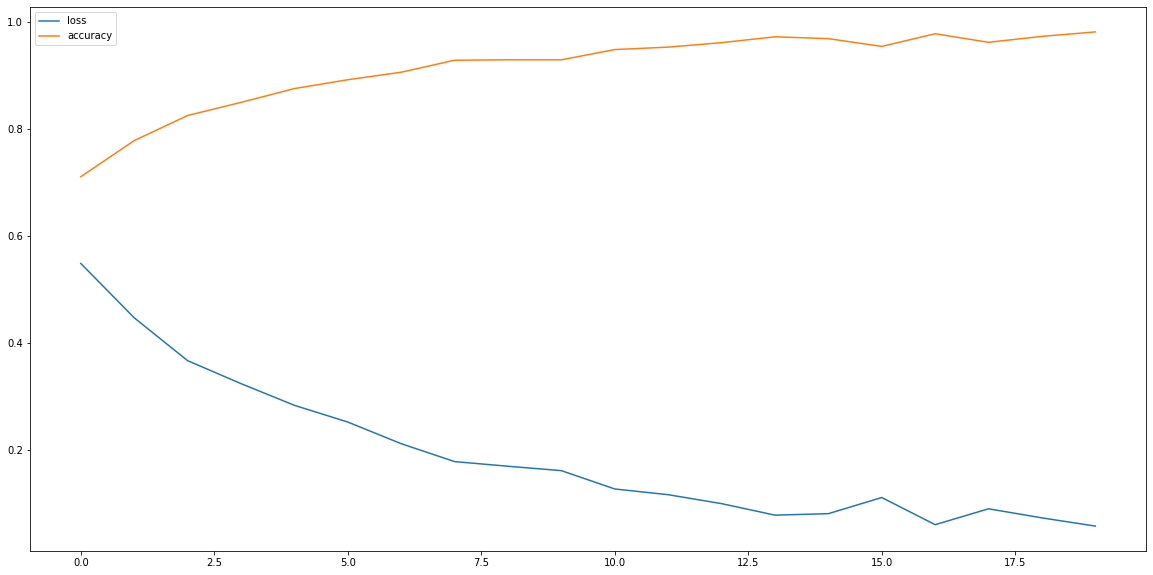

In [77]:
plot_loss_acc(results)